In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from root_numpy import root2array

from sklearn import preprocessing, datasets
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sknn.mlp import Regressor, Layer
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve

import pickle

/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


First we define our input branches.

We import 80 kinematic branches. Jon suggests either narrowing this down *manually*, or printing out PCA or other diagnostics so we can see which branches are important). The goal here is to convince the old people that machine learning is not a black box.

In [2]:
importBranches = ['lep_pT[0]','lep_pT[1]','lep_pT[2]','lep_pT[3]','lep_pT[4]',
            'lep_eta[0]','lep_eta[1]','lep_eta[2]','lep_eta[3]','lep_eta[4]',
            'lep_phi[0]','lep_phi[1]','lep_phi[2]','lep_phi[3]','lep_phi[4]',
            'lep_m[0]','lep_m[1]','lep_m[2]','lep_m[3]','lep_m[4]',
            'lep_E[0]','lep_E[1]','lep_E[2]','lep_E[3]','lep_E[4]',
            'jet_pT[0]','jet_pT[1]','jet_pT[2]','jet_pT[3]','jet_pT[4]',
            'jet_eta[0]','jet_eta[1]','jet_eta[2]','jet_eta[3]','jet_eta[4]',
            'jet_phi[0]','jet_phi[1]','jet_phi[2]','jet_phi[3]','jet_phi[4]',
            'jet_m[0]','jet_m[1]','jet_m[2]','jet_m[3]','jet_m[4]',
            'jet_E[0]','jet_E[1]','jet_E[2]','jet_E[3]','jet_E[4]',
            'Z_pt[0]','Z_pt[1]','Z_pt[2]','Z_pt[3]','Z_pt[4]',
            'Z_phi[0]','Z_phi[1]','Z_phi[2]','Z_phi[3]','Z_phi[4]',
            'Z_eta[0]','Z_eta[1]','Z_eta[2]','Z_eta[3]','Z_eta[4]',
            'nVtx','MT2Top','MT2W','lep_n','jet_n','bjet_n','mu_n','el_n',
            'mll','HT','VecHT','HTincl','VecHTincl','MET','MET_phi']

Here is a function for importing samples. The stuff is all imported in structured array form, which is a pain in the ass, so we change this to a normal array. Each row is an event, and each column is a feature.

In [3]:
def importSample(ID, branches=importBranches):
    
    fileName = '../Data/SleptonSignalBackground/%d.root' % ID
    array = root2array(fileName, 'outputTree', branches=branches)
    array = array.view((float, len(array.dtype.names)))
    return array

We import ttbar for the background, three slepton models for training and validation, and an additional three for testing the generality of our algorithm.

In [4]:
ttbar = importSample(410000)

s1200_500 = importSample(372462)
s1400_100 = importSample(372466)
s1000_800 = importSample(372498)

s800_100 = importSample(372453)
s1200_700 = importSample(372463)
s1600_900 = importSample(372476)

In [8]:
s1600_900.shape

(13223, 80)

We define our signal regions. These are used to fill new branches, where each selection acts as a boolean filter, which is filled with either a 0 or a 1 based on whether or not an event passes.

For instance, sum(ttbar_SR[:,2])=570 is the number of events in ttbar which pass SR High.

In [37]:
trigger = "((channel==1 && eetrig && eetrig_match)"\
        "|| (channel==0 && mmtrig && mmtrig_match)"\
        "|| (channel>=2 && emtrig && emtrig_match))"
lepReq = "((lep_n>=2 && lep_pT[0]>25 && lep_pT[1]>25) && (lep_pdgId[0] == -lep_pdgId[1]))"
jetReq = "(jet_n>=2 && jet_pT[0]>30 && jet_pT[1]>30)"
dPhiJetMET = "(DPhi_METJetLeading>0.4 && DPhi_METJetSecond>0.4)"

EdgeSR = trigger + " && " + lepReq + " && " + jetReq + " && " + dPhiJetMET + " && mll>12"
EdgeSRLow = EdgeSR + " && MET>200";
EdgeSRMed = EdgeSR + " && MET>250 && HT>400";
EdgeSRHigh = EdgeSR + " && MET>200 && HT>700";

SRbranches = [EdgeSRLow, EdgeSRMed, EdgeSRHigh]

ttbar_SR = importSample(410000, SRbranches)

s1200_500_SR = importSample(372462, SRbranches)
s1400_100_SR = importSample(372466, SRbranches)
s1000_800_SR = importSample(372498, SRbranches)

s800_100_SR = importSample(372453, SRbranches)
s1200_700_SR = importSample(372463, SRbranches)
s1600_900_SR = importSample(372476, SRbranches)

Three arrays here: X, process, and region.

X is all the ttbar and slepton data (for first three slepton models), with ttbar stacked on top of the sleptons.  
process is 0 for ttbar, 1 for (1200,500), etc., and will later be altered into a 0/1 (ttbar/slepton) array for training.  
region is 0 for inclusive, 1 for SR Low, etc.  

process and region are row vectors, but it doesn't matter. X is scaled so that each feature has mean 0 and sigma 1.

In [38]:
X = np.concatenate((ttbar, s1200_500, s1400_100, s1000_800), axis=0)

type0 = np.zeros(ttbar.shape[0])
type1 = np.ones(s1200_500.shape[0])
type2 = np.ones(s1400_100.shape[0])*2
type3 = np.ones(s1000_800.shape[0])*3
process = np.concatenate((type0, type1, type2, type3))

region = np.concatenate((ttbar_SR, s1200_500_SR, s1400_100_SR, s1000_800_SR), axis=0)
region = region.sum(axis=1)

X = preprocessing.scale(X)

We also create arrays X2, process2, and region2. These contain data for slepton models that we did not explicitly train for. Note that we have to include ttbar in the mix because if we don't, the scaling will be all messed up and our neural net will train horribly.

In [39]:
X2 = np.concatenate((ttbar, s800_100, s1200_700, s1600_900), axis=0)

type4 = np.ones(s800_100.shape[0])*4
type5 = np.ones(s1200_700.shape[0])*5
type6 = np.ones(s1600_900.shape[0])*6
process2 = np.concatenate((type0, type4, type5, type6))

region2 = np.concatenate((ttbar_SR, s800_100_SR, s1200_700_SR, s1600_900_SR), axis=0)
region2 = region2.sum(axis=1)

X2 = preprocessing.scale(X2)

After scaling, we reduce the dimensionality of X and X2.

In [40]:
#pca = PCA(0.95) #retain 95% variance
#pca.fit(X)

#X = pca.transform(X)
#X2 = pca.transform(X2)

#print('retained variance: %f' % sum(pca.explained_variance_ratio_))
#print('%d components' % pca.n_components_)

We shuffle the events around in X, signalType, and process together so that their relationship is maintained. The same for the second set of arrays.

In [41]:
def shuffle_in_unison(a, b, c):
    
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    np.random.set_state(rng_state)
    np.random.shuffle(c)

shuffle_in_unison(X, process, region)
shuffle_in_unison(X2, process2, region2)

Recap:  
X[i] is data for event i, (with the list of events having been shuffled). This is a list of n parameters, where n is the number of branches we imported.  
process[i] states what kind of event it is, with 0 being ttbar.  
region[i] is a 3-tuple stating whether the event passes SR Low, Med, and High.

The second set of arrays is the same deal, but it contains only a booster pack of new signal events.

Now we split the arrays into training (60%), validation (20%), and test (20%) sets. The second set of arrays does not need to be split, as it is all test data.

We also create the training data, y, based on whether the process is ttbar or signal.

In [42]:
index = np.arange(process.size)

y = 1*(process>0)
X_dev, X_test, index_dev, index_test = train_test_split(X, index, test_size=0.2)
X_train, X_val, index_train, index_val = train_test_split(X_dev, index_dev, test_size=0.25)

region_train = region[index_train]
region_val = region[index_val]
region_test = region[index_test]
process_train = process[index_train]
process_val = process[index_val]
process_test = process[index_test]
y_train = y[index_train]
y_val = y[index_val]
y_test = y[index_test]

y2 = 1*(process2>0)

Neural net training with default parameters, as optimized from before. Save the resulting neural net.

In [43]:
def trainNN(learning_rate=0.02, n_iter=20, m=X_train.shape[0], neurons=7, weight=1):
    
    nn = Regressor(layers=[Layer("Tanh", units=neurons),
                   Layer("Tanh", units=neurons), Layer("Tanh")],
                   learning_rate=learning_rate, n_iter=n_iter)
    if weight != 1:
        weight_train = np.ones(m)
        weight_train[y_train[0:m-1] == 1] = weight #weigh signal events
        nn.fit(X_train[0:m-1][:], y_train[0:m-1][:], weight_train)
    else:
        nn.fit(X_train[0:m-1][:], y_train[0:m-1][:])
    return nn

In [45]:
#nn = trainNN()
#pickle.dump(nn, open('trainedNN_PCAReduced.pkl', 'wb'))
#nn=pickle.load(open('trainedNN.pkl','rb'))
nn=pickle.load(open('trainedNN_20160506.pkl','rb'))

Draw a precision-recall curve and use that to set the threshold for the working point we want.

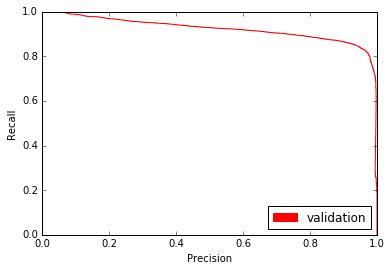

In [46]:
valRawPredictions = nn.predict(X_val)
precisions, recalls, thresholds = precision_recall_curve(y_val, valRawPredictions)
plt.plot(precisions,recalls,'r-')
plt.xlabel("Precision")
plt.ylabel("Recall")
valLine = mpatches.Patch(color='red', label='validation')
plt.legend(handles=[valLine], loc='lower right')
plt.show()

In [47]:
threshold = 0.5

Print total accuracy, precision, and recall on the test set.

In [48]:
prediction = np.round(nn.predict(X_test) - (threshold-0.5))
testAccuracy = accuracy_score(y_test, prediction)
testPrecision = precision_score(y_test, prediction)
testRecall = recall_score(y_test, prediction)

print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f"
      % (testAccuracy, testPrecision, testRecall))

Accuracy: 0.99, Precision: 0.96, Recall: 0.84


Now do it for each signal type, and again for each region, then again on additional signal samples. "SR" stands for signal region, but whatever, let's use it for the signal models too.

In [49]:
regionName = ["SR Low", "SR Med", "SR High"]
processName = ["ttbar", "(1200,500)", "(1400,100)", "(1000,800)",
               "(800,100)", "(1200,700)", "(1600,900)"]

for i in range(0,3):
    print("Region %s:" % regionName[i])
    X_SR = X_test[region_test==i]
    y_SR = y_test[region_test==i]
    prediction = np.round(nn.predict(X_SR) - (threshold-0.5))
    testAccuracy = accuracy_score(y_SR, prediction)
    testPrecision = precision_score(y_SR, prediction)
    testRecall = recall_score(y_SR, prediction)
    print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f"
          % (testAccuracy, testPrecision, testRecall))
    
for i in range(1,4):
    print("Process %s:" % processName[i])
    X_SR = X_test[process_test==i]
    y_SR = y_test[process_test==i]
    prediction = np.round(nn.predict(X_SR) - (threshold-0.5))
    testAccuracy = accuracy_score(y_SR, prediction)
    testPrecision = precision_score(y_SR, prediction)
    testRecall = recall_score(y_SR, prediction)
    print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f"
          % (testAccuracy, testPrecision, testRecall))

print("\nTesting completely new signal models:\n")
    
for i in range(0,3):
    print("Region %s:" % regionName[i])
    X_SR = X2[region2==i]
    y_SR = y2[region2==i]
    prediction = np.round(nn.predict(X_SR) - (threshold-0.5))
    testAccuracy = accuracy_score(y_SR, prediction)
    testPrecision = precision_score(y_SR, prediction)
    testRecall = recall_score(y_SR, prediction)
    print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f"
          % (testAccuracy, testPrecision, testRecall))
    
for i in range(4,7):
    print("Process %s:" % processName[i])
    X_SR = X2[process2==i]
    y_SR = y2[process2==i]
    prediction = np.round(nn.predict(X_SR) - (threshold-0.5))
    testAccuracy = accuracy_score(y_SR, prediction)
    testPrecision = precision_score(y_SR, prediction)
    testRecall = recall_score(y_SR, prediction)
    print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f"
          % (testAccuracy, testPrecision, testRecall))

Region SR Low:
Accuracy: 0.99, Precision: 0.94, Recall: 0.72
Region SR Med:
Accuracy: 0.92, Precision: 0.94, Recall: 0.86
Region SR High:
Accuracy: 0.94, Precision: 0.98, Recall: 0.95
Process (1200,500):
Accuracy: 0.93, Precision: 1.00, Recall: 0.93
Process (1400,100):
Accuracy: 0.98, Precision: 1.00, Recall: 0.98
Process (1000,800):
Accuracy: 0.49, Precision: 1.00, Recall: 0.49

Testing completely new signal models:

Region SR Low:
Accuracy: 0.99, Precision: 0.90, Recall: 0.85
Region SR Med:
Accuracy: 0.92, Precision: 0.95, Recall: 0.92
Region SR High:
Accuracy: 0.96, Precision: 0.98, Recall: 0.98
Process (800,100):
Accuracy: 0.91, Precision: 1.00, Recall: 0.91
Process (1200,700):
Accuracy: 0.85, Precision: 1.00, Recall: 0.85
Process (1600,900):
Accuracy: 0.95, Precision: 1.00, Recall: 0.95


## END

In [19]:
sum(prediction)

array([ 2846.])

In [20]:
y_SR.shape

(13223,)

In [ ]:
plt.hist(X_sub[:,78],range=(-3,3))